### Importing libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchsummary import summary
import albumentations as A
# from torchvision import datasets, transforms
import importlib
from torch_lr_finder import LRFinder
from utils import utils
from utils.utils import fabric
from utils.dataset import Dataset
from utils.scheduler import Scheduler
import warnings

warnings.filterwarnings('ignore')

Using bfloat16 Automatic Mixed Precision (AMP)
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


In [2]:
# Initialize
utils.set_seed(1)

### Import dataset: CIFAR10

In [3]:
dataset = Dataset('CIFAR10', batch_size=512)

Files already downloaded and verified
Files already downloaded and verified
The mean and SD for CIFAR10 dataset are [0.49139968 0.48215841 0.44653091] and [0.24703223 0.24348513 0.26158784] respectively.
Files already downloaded and verified
Files already downloaded and verified


In [4]:
train_loader, test_loader = dataset.get_data_loaders()

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# dataiter = iter(train_loader)
# images, labels = next(dataiter)
# images.shape, labels.shape

(torch.Size([512, 3, 32, 32]), torch.Size([512]))

### Visualize input images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

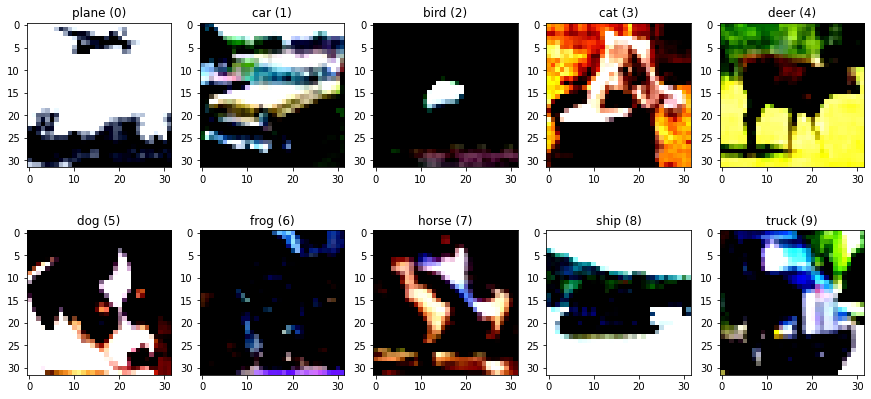

In [6]:
label_mapper = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
# images, labels = next(dataiter)
# utils.visualize_images(images, labels, label_mapper, n_cols=5, figsize=(15, 7))

### Model Training

#### Model 1

In [7]:
from models import custom_resnet
importlib.reload(custom_resnet)

<module 'models.custom_resnet' from 'd:\\Self Learning\\TSAI\\TSAI\\S10\\models\\custom_resnet.py'>

In [8]:
from models.custom_resnet import CustomResNet
device = utils.get_device()
in_ch = 3
model_1 = CustomResNet(in_ch=in_ch).to(device)
summary(model_1, input_size=(in_ch, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
       BatchNorm2d-5          [-1, 128, 32, 32]             256
              ReLU-6          [-1, 128, 32, 32]               0
         MaxPool2d-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 256,

### LR Finder

  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.38E-02


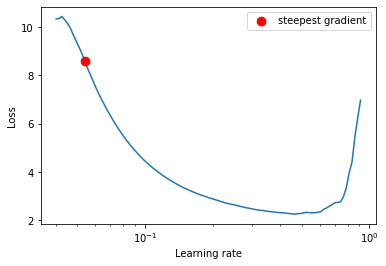

In [9]:
model = CustomResNet(in_ch=in_ch).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.03, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=10, num_iter=200, step_mode="exp")
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [10]:
num_epochs = 24
max_lr = 5.38E-02
steps_per_epoch = len(train_loader)

scheduler = Scheduler('OneCycleLR', {
    'optimizer': optimizer,
    'max_lr': max_lr,
    'steps_per_epoch': steps_per_epoch, 
    'epochs': num_epochs, 
    'pct_start': 5/num_epochs,
    'div_factor': 100,
    'final_div_factor': 100,
    'three_phase': False,
    'anneal_strategy': 'linear',
    'verbose': False
})

for epoch in range(1, num_epochs+1):
    print('EPOCH:', epoch)
    model.model_train(device, train_loader, criterion, optimizer, scheduler)
    model.model_test(device, test_loader, criterion)

EPOCH: 1


  0%|          | 0/98 [00:00<?, ?it/s]

Train: Loss=1.2018365859985352 Batch_id=97 Accuracy=52.53: 100%|██████████| 98/98 [00:50<00:00,  1.93it/s]


Test: Average loss: 0.0023, Accuracy: 6037/10000 (60.37%), Accuracy Diff: 7.838

EPOCH: 2


Train: Loss=0.9197058081626892 Batch_id=97 Accuracy=65.13: 100%|██████████| 98/98 [00:50<00:00,  1.95it/s]


Test: Average loss: 0.0025, Accuracy: 5685/10000 (56.85%), Accuracy Diff: 8.278

EPOCH: 3


Train: Loss=0.6728208065032959 Batch_id=97 Accuracy=73.05: 100%|██████████| 98/98 [00:51<00:00,  1.89it/s]


Test: Average loss: 0.0024, Accuracy: 6402/10000 (64.02%), Accuracy Diff: 9.034

EPOCH: 4


Train: Loss=0.59849613904953 Batch_id=97 Accuracy=77.22: 100%|██████████| 98/98 [00:51<00:00,  1.91it/s]  


Test: Average loss: 0.0025, Accuracy: 6486/10000 (64.86%), Accuracy Diff: 12.364

EPOCH: 5


Train: Loss=0.6790336966514587 Batch_id=97 Accuracy=79.10: 100%|██████████| 98/98 [00:53<00:00,  1.83it/s] 


Test: Average loss: 0.0024, Accuracy: 6424/10000 (64.24%), Accuracy Diff: 14.862

EPOCH: 6


Train: Loss=0.5620472431182861 Batch_id=97 Accuracy=79.48: 100%|██████████| 98/98 [00:48<00:00,  2.01it/s] 


Test: Average loss: 0.0027, Accuracy: 5757/10000 (57.57%), Accuracy Diff: 21.91

EPOCH: 7


Train: Loss=0.5901023745536804 Batch_id=97 Accuracy=80.58: 100%|██████████| 98/98 [00:50<00:00,  1.95it/s] 


Test: Average loss: 0.0016, Accuracy: 7440/10000 (74.40%), Accuracy Diff: 6.178

EPOCH: 8


Train: Loss=0.5483075976371765 Batch_id=97 Accuracy=80.89: 100%|██████████| 98/98 [00:50<00:00,  1.95it/s] 


Test: Average loss: 0.0018, Accuracy: 6855/10000 (68.55%), Accuracy Diff: 12.338

EPOCH: 9


Train: Loss=0.5880135297775269 Batch_id=97 Accuracy=81.42: 100%|██████████| 98/98 [00:49<00:00,  1.99it/s] 


Test: Average loss: 0.0016, Accuracy: 7261/10000 (72.61%), Accuracy Diff: 8.81

EPOCH: 10


Train: Loss=0.4934104382991791 Batch_id=97 Accuracy=81.64: 100%|██████████| 98/98 [00:52<00:00,  1.86it/s] 


Test: Average loss: 0.0019, Accuracy: 6952/10000 (69.52%), Accuracy Diff: 12.116

EPOCH: 11


Train: Loss=0.5718684196472168 Batch_id=97 Accuracy=82.84: 100%|██████████| 98/98 [01:06<00:00,  1.48it/s] 


Test: Average loss: 0.0019, Accuracy: 6949/10000 (69.49%), Accuracy Diff: 13.352

EPOCH: 12


Train: Loss=0.5074658989906311 Batch_id=97 Accuracy=83.20: 100%|██████████| 98/98 [00:52<00:00,  1.85it/s] 


Test: Average loss: 0.0014, Accuracy: 7603/10000 (76.03%), Accuracy Diff: 7.174

EPOCH: 13


Train: Loss=0.6197344660758972 Batch_id=97 Accuracy=83.36: 100%|██████████| 98/98 [00:51<00:00,  1.90it/s] 


Test: Average loss: 0.0017, Accuracy: 7188/10000 (71.88%), Accuracy Diff: 11.484

EPOCH: 14


Train: Loss=0.5589238405227661 Batch_id=97 Accuracy=84.49: 100%|██████████| 98/98 [00:54<00:00,  1.81it/s] 


Test: Average loss: 0.0017, Accuracy: 7210/10000 (72.10%), Accuracy Diff: 12.386

EPOCH: 15


Train: Loss=0.4690566658973694 Batch_id=97 Accuracy=85.31: 100%|██████████| 98/98 [00:59<00:00,  1.65it/s] 


Test: Average loss: 0.0020, Accuracy: 6841/10000 (68.41%), Accuracy Diff: 16.904

EPOCH: 16


Train: Loss=0.46884459257125854 Batch_id=97 Accuracy=85.69: 100%|██████████| 98/98 [00:48<00:00,  2.01it/s]


Test: Average loss: 0.0015, Accuracy: 7477/10000 (74.77%), Accuracy Diff: 10.922

EPOCH: 17


Train: Loss=0.3969239592552185 Batch_id=97 Accuracy=87.11: 100%|██████████| 98/98 [00:55<00:00,  1.76it/s] 


Test: Average loss: 0.0013, Accuracy: 7747/10000 (77.47%), Accuracy Diff: 9.638

EPOCH: 18


Train: Loss=0.37999528646469116 Batch_id=97 Accuracy=88.11: 100%|██████████| 98/98 [00:57<00:00,  1.71it/s]


Test: Average loss: 0.0010, Accuracy: 8313/10000 (83.13%), Accuracy Diff: 4.98

EPOCH: 19


Train: Loss=0.5416814088821411 Batch_id=97 Accuracy=89.71: 100%|██████████| 98/98 [00:50<00:00,  1.94it/s] 


Test: Average loss: 0.0010, Accuracy: 8247/10000 (82.47%), Accuracy Diff: 7.244

EPOCH: 20


Train: Loss=0.3945043087005615 Batch_id=97 Accuracy=91.43: 100%|██████████| 98/98 [01:06<00:00,  1.47it/s] 


Test: Average loss: 0.0012, Accuracy: 8083/10000 (80.83%), Accuracy Diff: 10.602

EPOCH: 21


Train: Loss=0.2704549729824066 Batch_id=97 Accuracy=93.53: 100%|██████████| 98/98 [00:55<00:00,  1.75it/s] 


Test: Average loss: 0.0011, Accuracy: 8178/10000 (81.78%), Accuracy Diff: 11.754

EPOCH: 22


Train: Loss=0.13715453445911407 Batch_id=97 Accuracy=96.18: 100%|██████████| 98/98 [00:55<00:00,  1.75it/s]


Test: Average loss: 0.0009, Accuracy: 8642/10000 (86.42%), Accuracy Diff: 9.756

EPOCH: 23


Train: Loss=0.029022391885519028 Batch_id=97 Accuracy=98.83: 100%|██████████| 98/98 [00:55<00:00,  1.76it/s]


Test: Average loss: 0.0008, Accuracy: 8779/10000 (87.79%), Accuracy Diff: 11.044

EPOCH: 24


Train: Loss=0.007776543498039246 Batch_id=97 Accuracy=99.94: 100%|██████████| 98/98 [00:52<00:00,  1.86it/s] 


Test: Average loss: 0.0008, Accuracy: 8857/10000 (88.57%), Accuracy Diff: 11.374



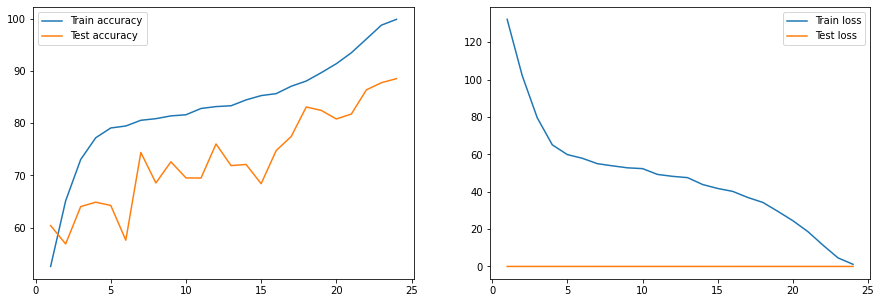

In [11]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
model.plot_accuracy()
plt.subplot(122)
model.plot_loss()
# plt.savefig('images/model_1.png')
plt.show()

In [12]:
max(model.train_accuracy), max(model.test_accuracy)

(99.944, 88.57)

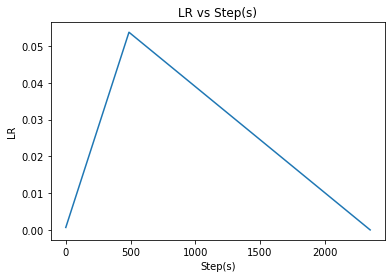

In [13]:
scheduler.plot_lr_change()

### Visualizing incorrect predictions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

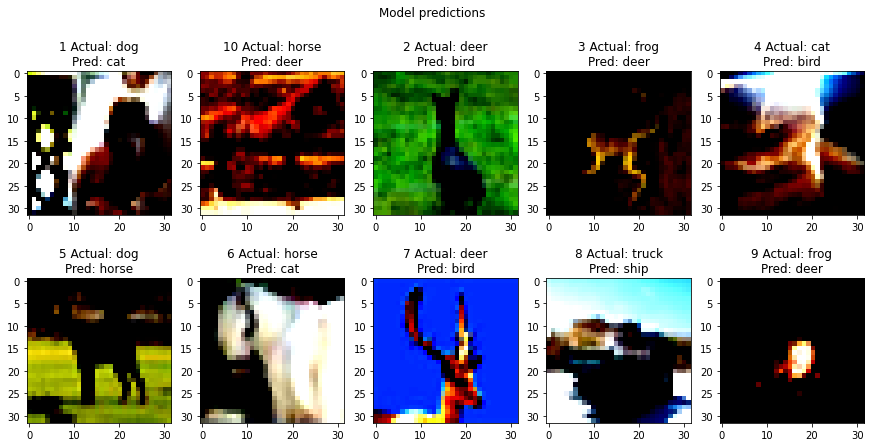

In [7]:
label_mapper = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
images, actual, pred = model_5.get_incorrect_pred(device, test_loader)
images, actual, pred = images.to('cpu'), actual.to('cpu'), pred.to('cpu')
labels = [str(indx + 1) + ' Actual: %s' % label_mapper[act.item()] + '\n' + \
    'Pred: %s' % label_mapper[pr.item()] for indx, (act, pr) in enumerate(zip(actual, pred))]
utils.visualize_images(images, labels, n_cols=5, figsize=(15, 7), img_title='Model predictions')